In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# tf.debugging.set_log_device_placement(True)
print(tf.__version__)

2.3.1


In [3]:
tf.test.is_built_with_cuda()
# tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

True

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  0


[]

In [5]:
TRAIN_COUNT = 10000

In [6]:
data = pd.read_excel('Simulation.xlsx')

In [7]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)

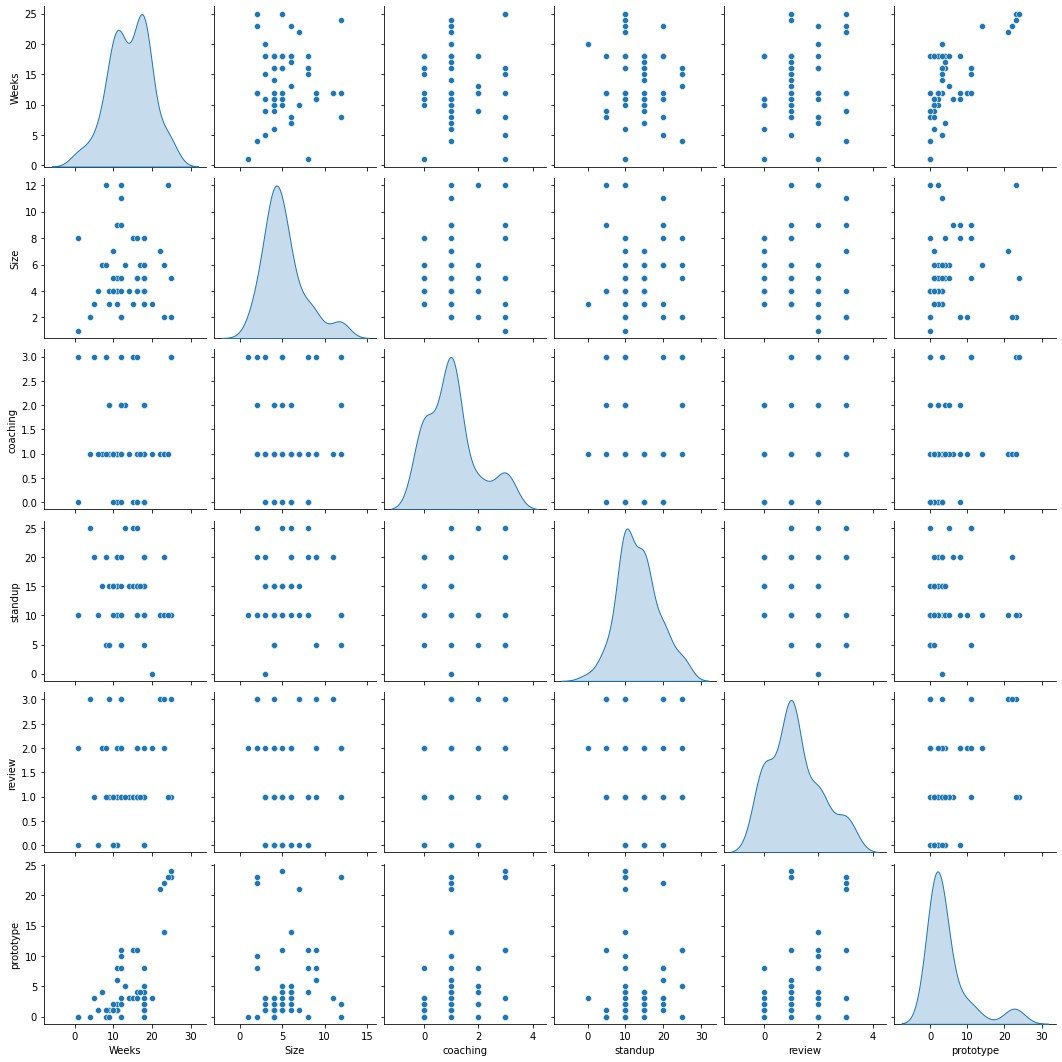

In [8]:
sns.pairplot(train_dataset[['Weeks', 'Size', 'coaching', 'standup', 'review','prototype']], diag_kind='kde')

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Result')
test_labels = test_features.pop('Result')

In [10]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Weeks,14.212121,5.365173
Size,5.166667,2.446871
skill 1,0.378788,0.488802
skill 2,0.212121,0.411943
skill 3,0.106061,0.310275
skill 4,0.303030,0.463090
coaching,1.045455,0.935321
standup,13.333333,5.286655
review,1.136364,0.926306
overtime 1,0.181818,0.388650


In [11]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[14.212  5.167  0.379  0.212  0.106  0.303  1.045 13.333  1.136  0.182
  0.424  0.394  4.561]


In [12]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 9  3  0  0  1  0  1 15  1  0  0  1  1]]

Normalized: [[-0.98 -0.89 -0.78 -0.52  2.9  -0.66 -0.05  0.32 -0.15 -0.47 -0.86  1.24
  -0.6 ]]


In [13]:
Size = np.array(train_features['Size'])

Size_normalizer = preprocessing.Normalization(input_shape=[1,])
Size_normalizer.adapt(Size)

In [14]:
Size_model = tf.keras.Sequential([
    Size_normalizer,
    layers.Dense(units=10)
])

Size_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 10)                20        
Total params: 23
Trainable params: 20
Non-trainable params: 3
_________________________________________________________________


In [15]:
Size_model.predict(Size[:10])

array([[ 0.19 ,  0.066, -0.404,  0.02 , -0.278,  0.164, -0.261, -0.51 ,
         0.097, -0.594],
       [ 0.277,  0.097, -0.591,  0.03 , -0.406,  0.239, -0.381, -0.745,
         0.142, -0.868],
       [ 0.015,  0.005, -0.031,  0.002, -0.021,  0.013, -0.02 , -0.039,
         0.007, -0.046],
       [-0.073, -0.026,  0.155, -0.008,  0.107, -0.063,  0.1  ,  0.196,
        -0.037,  0.228],
       [ 0.102,  0.036, -0.218,  0.011, -0.149,  0.088, -0.14 , -0.275,
         0.052, -0.32 ],
       [ 0.102,  0.036, -0.218,  0.011, -0.149,  0.088, -0.14 , -0.275,
         0.052, -0.32 ],
       [ 0.102,  0.036, -0.218,  0.011, -0.149,  0.088, -0.14 , -0.275,
         0.052, -0.32 ],
       [ 0.277,  0.097, -0.591,  0.03 , -0.406,  0.239, -0.381, -0.745,
         0.142, -0.868],
       [ 0.102,  0.036, -0.218,  0.011, -0.149,  0.088, -0.14 , -0.275,
         0.052, -0.32 ],
       [ 0.19 ,  0.066, -0.404,  0.02 , -0.278,  0.164, -0.261, -0.51 ,
         0.097, -0.594]], dtype=float32)

In [16]:
Size_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    # optimizer=tf.optimizers.Adam(learning_rate=0),
    loss='mean_absolute_error')

In [17]:
class Print(keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs): 
        print (str(epoch)+' / '+str(TRAIN_COUNT), end="\r")

In [18]:
%%time
history = Size_model.fit(
    train_features['Size'], train_labels,
    epochs=TRAIN_COUNT,
    # epochs=1000,
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    callbacks=[Print()]
    )

Wall time: 2min 35s


In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
9995,127.482819,47.745537,9995
9996,127.481979,47.747677,9996
9997,127.482582,47.749775,9997
9998,127.482269,47.755436,9998
9999,127.483604,47.755550,9999


In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Result]')
  plt.legend()
  plt.grid(True)

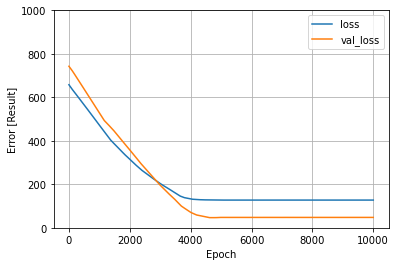

In [21]:
plot_loss(history)

In [22]:
test_results = {}
test_results['Size_model'] = Size_model.evaluate(
    test_features['Size'],
    test_labels, verbose=0)

In [23]:
x = tf.linspace(0.0, 12, 13)
y = Size_model.predict(x)

In [24]:
def plot_Size(x, y):
  plt.scatter(train_features['Size'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Size')
  plt.ylabel('Result')
  plt.legend()

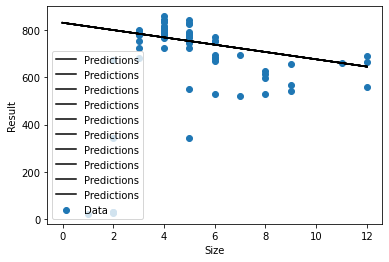

In [25]:
plot_Size(x,y)

In [26]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [27]:
linear_model.predict(train_features[:10])

array([[-0.999],
       [-2.432],
       [ 0.592],
       [-1.849],
       [-1.08 ],
       [ 0.225],
       [-0.102],
       [ 0.391],
       [-1.024],
       [-0.564]], dtype=float32)

In [28]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(13, 1) dtype=float32, numpy=
array([[ 0.484],
       [ 0.569],
       [-0.22 ],
       [ 0.499],
       [ 0.074],
       [ 0.248],
       [ 0.596],
       [ 0.042],
       [-0.504],
       [-0.631],
       [ 0.533],
       [ 0.067],
       [-0.06 ]], dtype=float32)>

In [29]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [30]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=TRAIN_COUNT,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2, 
    callbacks=[Print()]
    )

Wall time: 2min 37s


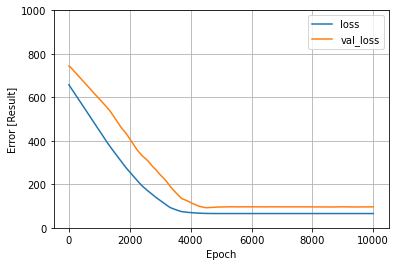

In [31]:
plot_loss(history)

In [32]:

test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [33]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
                # optimizer=tf.keras.optimizers.Adam(0.00001))
  return model

In [34]:
dnn_Size_model = build_and_compile_model(Size_normalizer)
dnn_Size_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [35]:
%%time
history = dnn_Size_model.fit(
    train_features['Size'], train_labels,
    validation_split=0.2,
    # validation_split=0,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 2min 33s


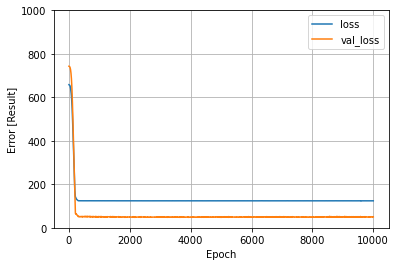

In [36]:
plot_loss(history)

In [37]:
x = tf.linspace(0.0, 12, 13)
y = dnn_Size_model.predict(x)

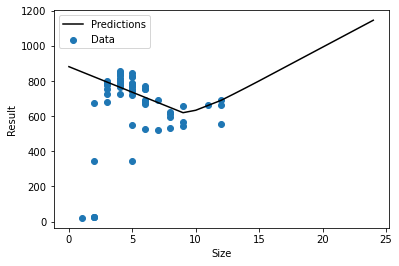

In [38]:
plot_Size(x, y)

In [39]:
test_results['dnn_Size_model'] = dnn_Size_model.evaluate(
    test_features['Size'], test_labels,
    verbose=0)

In [40]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 5,148
Trainable params: 5,121
Non-trainable params: 27
_________________________________________________________________


In [41]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=TRAIN_COUNT, 
    callbacks=[Print()]
    )

Wall time: 2min 40s


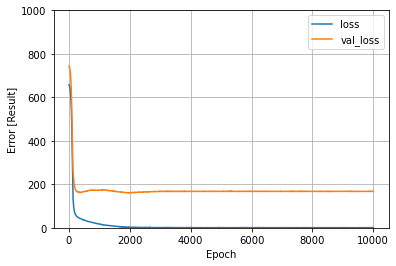

In [42]:
plot_loss(history)

In [43]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [44]:
pd.DataFrame(test_results, index=['Mean absolute error [Result]']).T

,Mean absolute error [Result]
Size_model,190.111694
linear_model,123.196976
dnn_Size_model,193.086258
dnn_model,109.701324


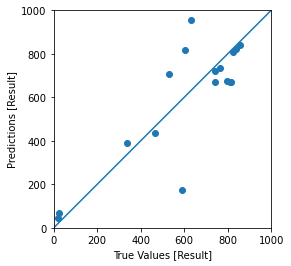

In [45]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Result]')
plt.ylabel('Predictions [Result]')
lims = [0, 1000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

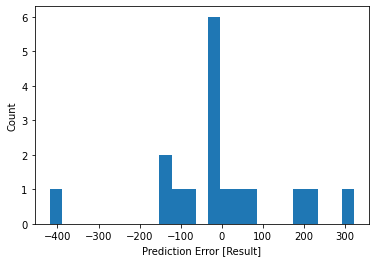

In [46]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Result]')
_ = plt.ylabel('Count')

In [47]:
dnn_model.save('dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model\assets
